In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility import *
from tools import *
from maps import *
from scipy.stats import linregress
from scipy.ndimage import maximum_filter, binary_dilation
from scipy.spatial.distance import cdist

In [162]:
# Load the Data's directory.
datadir = 'C:/Users/txu245/Desktop/26-02-17/Add/02_01_03.zda'

# Load the Tool Packages.
DataLoader = DataLoader(datadir)
Tools = Tools()
Maps = Maps()

In [163]:
# Parameters setting up.
index = np.linspace(0, 499.5, 1000)
basePt = 190
skipPt = 60
startPt = 190
numPt = 40

# Data Preprocessing.
Data = DataLoader.get_data()
Data = Tools.Polynomial(startPt=basePt, numPt=skipPt, Data=Data)
Rli = DataLoader.get_rli()
Data = Tools.Rli_Division(Rli=Rli, Data=Data)
Data = Tools.T_filter(Data=Data)
Data = Tools.S_filter(sigma=1, Data=Data)
Data_ave = np.mean(Data, axis=0)

# SNR Map. (Without Normalization)
snr_map = np.zeros((80, 80))

for i in range(80):
    for j in range(80):
        SD = np.std(Data_ave[i, j, 10:60], ddof=1)
        MaxAmp = np.max(Data_ave[i, j, startPt:(startPt+numPt)])
        SNR = MaxAmp / SD
        snr_map[i][j] = SNR

In [164]:
# Calculate the cutoff.
values = snr_map.flatten()
cutoff = np.percentile(values, 97.5)

# Find the local maximum.
def find_local_maxima_3x3(snr_map):
    h, w = snr_map.shape
    candidates = []

    for r in range(1, h-1):
        for c in range(1, w-1):
            window = snr_map[r-1:r+2, c-1:c+2]
            center = snr_map[r, c]

            if center == np.max(window) and np.sum(window == center) == 1 and center >= cutoff:
                candidates.append([r, c, snr_map[r, c]])

    return candidates

# Select those 3x3 areas without overlapping.
def select_non_overlapping(candidates, snr_map):
    candidates = sorted(candidates, key=lambda x: x[2], reverse=True)

    selected = []
    occupied = np.zeros_like(snr_map, dtype=bool)

    for r, c, snr_value in candidates:
        if not np.any(occupied[r-1:r+2, c-1:c+2]):
            selected.append([r, c])
            occupied[r-1:r+2, c-1:c+2] = True

    return selected

# Implement.
candidates = find_local_maxima_3x3(snr_map)
selected = select_non_overlapping(candidates, snr_map)
identified_map = np.zeros_like(snr_map, dtype=int)

for coor in selected:
    identified_map[coor[0]][coor[1]] = 1

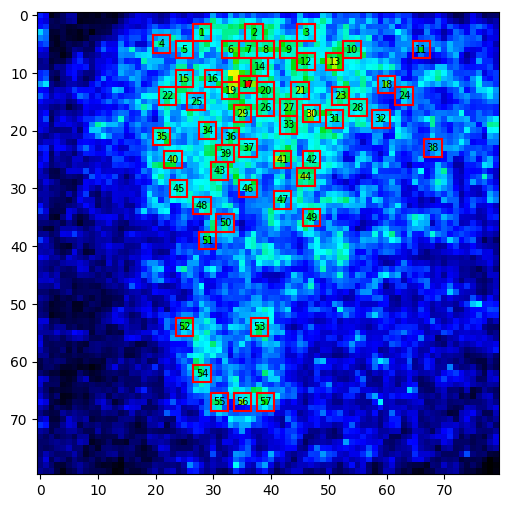

In [165]:
# Plotting.
linewidth = 1.5
color = 'red'

index = np.where(identified_map == 1)
index = np.transpose(index, (1, 0))

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(snr_map / np.max(snr_map), cmap=Maps.colorbar())

for i, coor in enumerate(index):

    #  Coordinates for columns and rows.   
    c = coor[0]
    r = coor[1]

    # Pixel boundaries.
    left   = c - 1.5
    right  = c + 1.5
    top    = r - 1.5
    bottom = r + 1.5

    # Draw square contour.
    ax.plot([top, top], [left, right], color=color, linewidth=linewidth)
    ax.plot([bottom, bottom], [left, right], color=color, linewidth=linewidth)
    ax.plot([top, bottom], [left, left], color=color, linewidth=linewidth)
    ax.plot([top, bottom], [right, right], color=color, linewidth=linewidth)

    # Label index.
    ax.annotate(str(i+1), xy=(r, c), ha='center', va='center', fontsize=7, color='black')

plt.show()

Neuron 1 and Neuron 51 are correlated with a positive slope, and the P-Value is: 0.036621 , distance is: 216.0833172644293 um.
Neuron 2 and Neuron 7 are correlated with a positive slope, and the P-Value is: 1e-05 , distance is: 18.973665961010276 um.
Neuron 2 and Neuron 14 are correlated with a positive slope, and the P-Value is: 0.002053 , distance is: 36.49657518178932 um.
Neuron 2 and Neuron 18 are correlated with a positive slope, and the P-Value is: 0.043366 , distance is: 148.18906842274163 um.
Neuron 2 and Neuron 27 are correlated with a positive slope, and the P-Value is: 0.007374 , distance is: 85.90692637965812 um.
Neuron 2 and Neuron 34 are correlated with a positive slope, and the P-Value is: 0.021825 , distance is: 112.72976536833562 um.
Neuron 2 and Neuron 47 are correlated with a positive slope, and the P-Value is: 4e-05 , distance is: 176.56726763474592 um.
Neuron 2 and Neuron 52 are correlated with a positive slope, and the P-Value is: 0.000139 , distance is: 314.35648

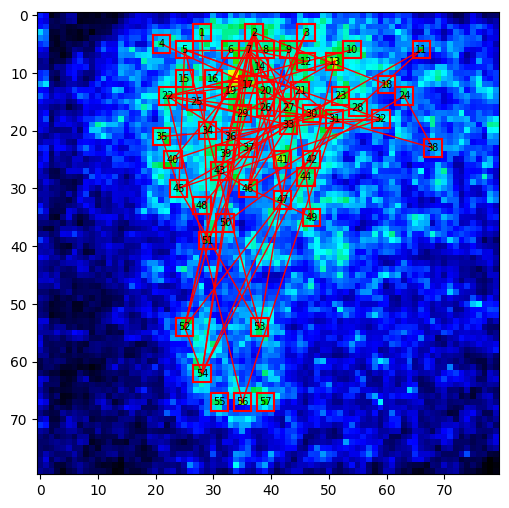

68 pairs are correlated.
Totally 1596 pairs.


In [166]:
num = len(index)
trial = Data.shape[0]
latency = np.zeros((num, trial))
count = 0

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(snr_map / np.max(snr_map), cmap=Maps.colorbar())

for i, coor in enumerate(index):

    #  Coordinates for columns and rows.   
    c = coor[0]
    r = coor[1]

    # Pixel boundaries.
    left   = c - 1.5
    right  = c + 1.5
    top    = r - 1.5
    bottom = r + 1.5

    # Draw square contour.
    ax.plot([top, top], [left, right], color=color, linewidth=linewidth)
    ax.plot([bottom, bottom], [left, right], color=color, linewidth=linewidth)
    ax.plot([top, bottom], [left, left], color=color, linewidth=linewidth)
    ax.plot([top, bottom], [right, right], color=color, linewidth=linewidth)

    # Label index.
    ax.annotate(str(i+1), xy=(r, c), ha='center', va='center', fontsize=7, color='black')

for i in range(num):
    for j in range(trial):

        Trace = np.mean(Data[j, index[i][0]-1:index[i][0]+2, index[i][1]-1:index[i][1]+2, :], axis=(0, 1))
        latency[i][j] = Maps.Half_Amp_Latency(Trace=Trace, startPt=startPt, numPt=numPt)

for i in range(num-1):
    for j in range(i+1, num):
        
        dist = np.sqrt((index[i][0] - index[j][0])**2 + (index[i][1] - index[j][1])**2) * 6
        Slope, _, _, pValue, _ = linregress(latency[i], latency[j])
        if pValue <=0.05 and Slope > 0:
            count = count + 1
            print('Neuron', i+1, 'and Neuron', j+1, 'are correlated with a positive slope, and the P-Value is:', np.round(pValue, 6), ', distance is:', dist, 'um.')
            loc_1 = index[i]
            loc_2 = index[j]

            ax.plot([loc_1[1], loc_2[1]], [loc_1[0], loc_2[0]], color='red', linewidth=1)

plt.show()

print(count, 'pairs are correlated.')
print('Totally', int(num*(num-1)/2), 'pairs.')

Neuron 3 and Neuron 46 are correlated with a positive slope, and the P-Value is: 0.016159 , distance is: 172.75416058665562 um.
Neuron 3 and Neuron 51 are correlated with a positive slope, and the P-Value is: 0.045998 , distance is: 238.8723508487326 um.


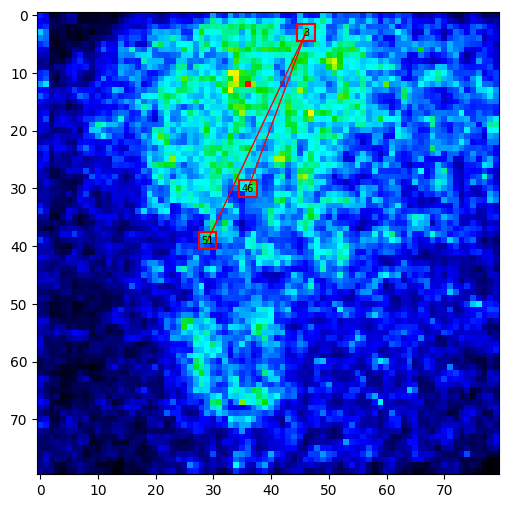

In [169]:
neuro_label = 3

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(snr_map / np.max(snr_map), cmap=Maps.colorbar())
top = index[neuro_label-1][1] - 1.5
bottom = index[neuro_label-1][1] + 1.5
left = index[neuro_label-1][0] - 1.5
right = index[neuro_label-1][0] + 1.5

ax.plot([top, top], [left, right], color=color, linewidth=linewidth)
ax.plot([bottom, bottom], [left, right], color=color, linewidth=linewidth)
ax.plot([top, bottom], [left, left], color=color, linewidth=linewidth)
ax.plot([top, bottom], [right, right], color=color, linewidth=linewidth)
ax.annotate(str(neuro_label), xy=(index[neuro_label-1][1], index[neuro_label-1][0]), ha='center', va='center', fontsize=7, color='black')

for i in range(num):

    if i == neuro_label - 1:
        continue
    else:
        dist = np.sqrt((index[i][0] - index[neuro_label-1][0])**2 + (index[i][1] - index[neuro_label-1][1])**2) * 6
        Slope, _, _, pValue, _ = linregress(latency[i], latency[neuro_label-1])

        if pValue <=0.05 and Slope > 0:
            count = count + 1
            print('Neuron', neuro_label, 'and Neuron', i+1, 'are correlated with a positive slope, and the P-Value is:', np.round(pValue, 6), ', distance is:', dist, 'um.')
            loc_1 = index[i]
            loc_2 = index[neuro_label-1]

            ax.plot([loc_1[1], loc_2[1]], [loc_1[0], loc_2[0]], color='red', linewidth=1)

            top = loc_1[1] - 1.5
            bottom = loc_1[1] + 1.5
            left = loc_1[0] - 1.5
            right = loc_1[0] + 1.5

            ax.plot([top, top], [left, right], color=color, linewidth=linewidth)
            ax.plot([bottom, bottom], [left, right], color=color, linewidth=linewidth)
            ax.plot([top, bottom], [left, left], color=color, linewidth=linewidth)
            ax.plot([top, bottom], [right, right], color=color, linewidth=linewidth)
            ax.annotate(str(i+1), xy=(loc_1[1], loc_1[0]), ha='center', va='center', fontsize=7, color='black')

plt.show()
        

In [168]:
index[2]

array([ 3, 46])